In [ ]:
% pip install torch torchvision torchaudio

UsageError: Line magic function `%` not found.


In [32]:
# LIBRARIES

import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import json
from sklearn.metrics import classification_report
from collections import Counter


In [33]:
# CONSTANTS

NUM_KEYPOINTS = 33  # MediaPipe's gives 33 landmakrs
FEATURES_PER_KEYPOINT = 2  # Only using (x, y) coordinates for now
SEQUENCE_LENGTH = 16  # Number of frames analyzed at a time
NUM_CLASSES = 3  # "eccentric", "concentric", "none"
LABEL_MAP = {"none": 0, "eccentric": 1, "concentric": 2}
INPUT_SIZE = NUM_KEYPOINTS * FEATURES_PER_KEYPOINT  # 66


In [34]:
class RepStageDataset(Dataset):
    def __init__(self, npy_path, json_path, sequence_length=16):
        self.pose_data = np.load(npy_path)[:, :66]  # (x, y) only
        with open(json_path) as f:
            labels = json.load(f)["rep_stages"]
        self.labels = [LABEL_MAP[l] for l in labels]
        self.seq_len = sequence_length
        assert len(self.pose_data) == len(self.labels)

    def __len__(self):
        return len(self.pose_data) - self.seq_len

    def __getitem__(self, idx):
        x = self.pose_data[idx : idx + self.seq_len]
        y = self.labels[idx + self.seq_len // 2]  # label for center frame
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y)


In [35]:
dataset = RepStageDataset(
    npy_path="../data/pose_np/sldl_israel_npy.npy",
    json_path="../data/label_data/sldl_israel_data.json",
    sequence_length=SEQUENCE_LENGTH
)

loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [36]:
# LSTM-based Rep Stage Classifier
# This model takes a short sequence of pose keypoints (e.g., 16 frames)
# and predicts the current stage of the exercise: eccentric or concentric.

class RepStageClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_classes=NUM_CLASSES):
        super(RepStageClassifier, self).__init__()
        
        # LSTM processes the input sequence of keypoints over time
        # input_size: features per frame (e.g., 66 for 33 keypoints × 2D)
        # hidden_size: size of LSTM's internal memory (can be tuned)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # Final linear layer maps LSTM output to class scores (eccentric/concentric)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Input x shape: (batch_size, sequence_length, input_size)
        
        # LSTM returns:
        # - out: LSTM outputs for each time step
        # - _: (hidden_state, cell_state), not used here
        out, _ = self.lstm(x)
        
        # We use the output from the last time step (i.e., the last frame in the sequence)
        # to make the final prediction
        out = self.fc(out[:, -1, :])  # shape: (batch_size, num_classes)
        return out

# Instantiate the model with the correct input size
model = RepStageClassifier(INPUT_SIZE)


In [44]:
# Define loss function — CrossEntropyLoss good for classification

# Count your dataset's label distribution
class_counts = Counter(dataset.labels)
total = sum(class_counts.values())

# Compute inverse frequency weights
weights = [total / class_counts[i] for i in range(NUM_CLASSES)]
weights = [1, 10, 10]

# Print them to verify (optional)
print("Class weights:", weights)

# Use the weighted loss
criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float32).to(device))


# Define optimizer — Adam widely used for sequence models like LSTM
optimizer = optim.Adam(model.parameters(), lr=0.001)


Class weights: [1, 10, 10]


In [45]:
# TRAINING LOOP
EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RepStageClassifier(INPUT_SIZE).to(device)

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Accuracy: {correct / total:.2%}")


Epoch 1 | Loss: 113.2450 | Accuracy: 13.01%
Epoch 2 | Loss: 113.2349 | Accuracy: 13.01%
Epoch 3 | Loss: 113.1904 | Accuracy: 13.01%
Epoch 4 | Loss: 113.2862 | Accuracy: 13.01%
Epoch 5 | Loss: 113.2474 | Accuracy: 13.01%
Epoch 6 | Loss: 113.2296 | Accuracy: 13.01%
Epoch 7 | Loss: 113.1979 | Accuracy: 13.01%
Epoch 8 | Loss: 113.2654 | Accuracy: 13.01%
Epoch 9 | Loss: 113.1955 | Accuracy: 13.01%
Epoch 10 | Loss: 113.2320 | Accuracy: 13.01%


In [39]:
# After training, evaluate
all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=["none", "eccentric", "concentric"]))


              precision    recall  f1-score   support

        none       0.00      0.00      0.00      2379
   eccentric       0.14      1.00      0.24       452
  concentric       0.00      0.00      0.00       475

    accuracy                           0.14      3306
   macro avg       0.05      0.33      0.08      3306
weighted avg       0.02      0.14      0.03      3306



/Users/israelavendanojr./Desktop/project-repos/mobile-app/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/israelavendanojr./Desktop/project-repos/mobile-app/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/israelavendanojr./Desktop/project-repos/mobile-app/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi

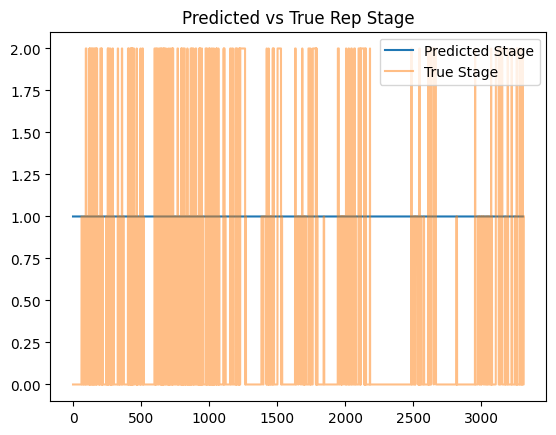

In [40]:
# Plot predicted stage vs. time
# Run inference on the entire sequence (no batching)
model.eval()
with torch.no_grad():
    preds = []
    for i in range(len(dataset)):
        x, _ = dataset[i]
        pred = model(x.unsqueeze(0).to(device)).argmax(dim=1).item()
        preds.append(pred)

import matplotlib.pyplot as plt
plt.plot(preds, label="Predicted Stage")
plt.plot(dataset.labels[SEQUENCE_LENGTH//2:], label="True Stage", alpha=0.5)
plt.legend()
plt.title("Predicted vs True Rep Stage")
plt.show()
